In [234]:
from typing import List, Dict
import xml.etree.ElementTree as ET

import utm
import folium
from folium import plugins
from folium.plugins import HeatMap
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

from datatypes import Simulation, CountPoint, Edge, Trip, TripInfo, TaxiSimulationLog
from utilities import retrieve

RES_DIR = '../temp/'

## **Retrive and process data**

In [235]:
simulation: Simulation = retrieve(RES_DIR + 'simulation.pkl')
count_points: List[CountPoint] = retrieve('../temp/filtered_count_points.pkl')
trips: List[Trip] = retrieve(RES_DIR + 'trips.pkl')
trip_ids = [str(trip.id) for trip in trips]
edges: List[Edge] = retrieve(RES_DIR + 'edges.pkl')

In [236]:
# f = folium.Map(location=[simulation.city.geometry['location']['lat'], simulation.city.geometry['location']['lng']], zoom_start = 12.5) 

# locs = []
# for trip in tqdm(trips):
#     edge = next(edge for edge in edges if edge.id == trip.from_)
#     loc = utm.to_latlon(edge.lanes[0].shape[0][0], edge.lanes[0].shape[0][1], 30, northern=True)
#     locs.append(loc)
#     # folium.Marker([loc[0], loc[1]], popup='London Bridge').add_to(f)

# HeatMap(locs).add_to(f)
# f

In [237]:
# Retrive data for base simulation

base_info_tree = ET.parse(RES_DIR + 'base.tripinfo.xml')
base_info_root = base_info_tree.getroot()
base_trip_infos: List[TripInfo] = {}

for trip_info in base_info_root.findall('tripinfo'):
    base_trip_infos[trip_info.attrib['id']] = TripInfo(
        trip_info.attrib['id'],
        '',
        float(trip_info.attrib['depart']),
        0.0,
        float(trip_info.attrib['duration']),
        float(trip_info.attrib['routeLength']),
        float(trip_info.attrib['timeLoss'])
    )

In [238]:
# Retrive data for taxi simulation

taxi_info_tree = ET.parse(RES_DIR + 'taxi.tripinfo.xml')
taxi_info_root = taxi_info_tree.getroot()
taxi_trip_infos: Dict[str, TripInfo] = {}
taxi_simulation_logs: List[TaxiSimulationLog] = retrieve(RES_DIR + 'taxi_simulation_log.pkl')

for trip_info in taxi_info_root.findall('personinfo'):
    ride_info = trip_info[0]
    taxi_trip_infos[trip_info.attrib['id']] = TripInfo(
        trip_info.attrib['id'],
        ride_info.attrib['vehicle'],
        float(trip_info.attrib['depart']),
        float(ride_info.attrib['waitingTime']),
        float(ride_info.attrib['duration']),
        float(ride_info.attrib['routeLength']),
        float(ride_info.attrib['timeLoss'])
    )

In [239]:
# Process and compare data

base_travel_times = []
taxi_travel_times = []
for trip_id in trip_ids:
    if (trip_id in base_trip_infos and trip_id in taxi_trip_infos):
        base_travel_times.append(base_trip_infos[trip_id].duration)
        taxi_travel_times.append(taxi_trip_infos[trip_id].duration)

print('test: {}, {}'.format(len(base_travel_times), len(taxi_travel_times)))
print('base travel time: {}, taxi travel time: {}'.format(sum(base_travel_times), sum(taxi_travel_times)))
print('taxi travel times is {}% more that the the duration of base travel times'.format(sum(taxi_travel_times)/sum(base_travel_times)*100))


test: 40925, 40925
base travel time: 21845584.0, taxi travel time: 21864555.0
taxi travel times is 100.08684134972083% more that the the duration of base travel times


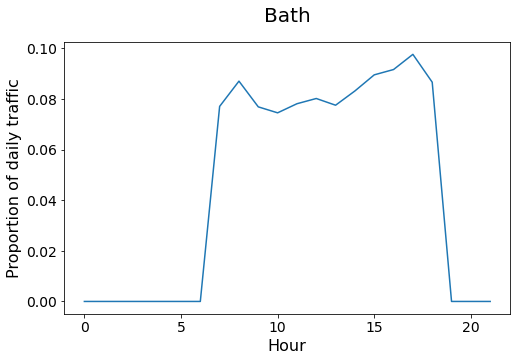

In [240]:
# Calculate traffic distribution based on count point data
aggregated_counts = [{'sum': 0, 'count': 0, 'average': 0, 'distribution_value': 0} for i in range(1, 23)];

# Aggregate count point data by time
for count_point in count_points:
    for count in count_point.counts:
        hour = count.hour

        if (hour < simulation.start_hour):
            simulation.start_hour = hour
        if (hour > simulation.end_hour):
            simulation.end_hour = hour

        aggregated_counts[count.hour]['sum'] += count.value_sum
        aggregated_counts[count.hour]['count'] += count.value_count

simulation.start_time = simulation.start_hour*3600
simulation.end_time = simulation.end_hour*3600

# Calculate distribution from aggregated data
total = 0;
for hour_count in aggregated_counts:
    if hour_count['count'] != 0:
        hour_count['average'] = hour_count['sum']/hour_count['count']
        total += hour_count['average']

for _, hour_count in enumerate(aggregated_counts):
    if hour_count['count'] != 0:
        hour_count['distribution_value'] = hour_count['average']/total

# title and axis labels
plt.title(simulation.city.name, pad=20)
plt.xlabel("Hour")
plt.ylabel("Proportion of daily traffic")

# plot
plt.plot([count['distribution_value'] for count in aggregated_counts])

plt.show()

## **Taxi graphs**

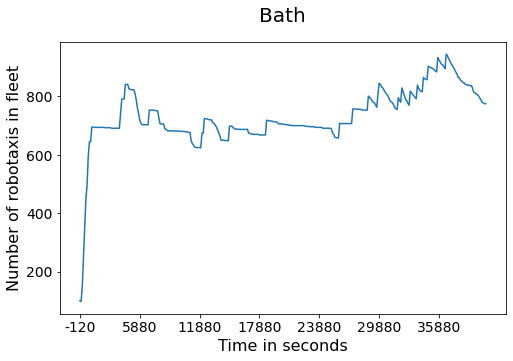

In [241]:
# Number of taxis in fleet over time

# title and axis labels
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Number of robotaxis in fleet")

# ticks
x_ticks_default = [i for i in range(0, len(taxi_simulation_logs), 50)]
x_ticks = [int(taxi_simulation_logs[i].time_step-simulation.start_time) for i in range(0, len(taxi_simulation_logs), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot([log.taxi_count for log in taxi_simulation_logs])

plt.show()

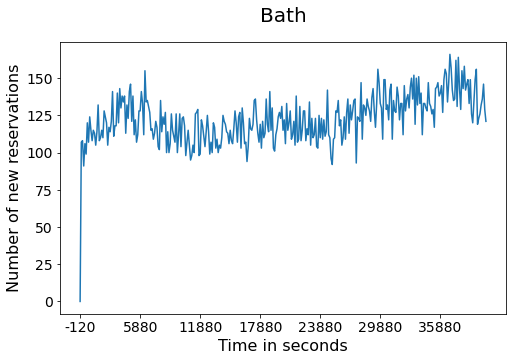

In [242]:
# Number of new reservations over time

reservation_counts = []
for i in range(1, len(taxi_simulation_logs)):
    reservation_counts.append(
        taxi_simulation_logs[i].reservation_count - taxi_simulation_logs[i-1].reservation_count
    )

# title and axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Number of new reservations")

# ticks
x_ticks_default = [i for i in range(0, len(taxi_simulation_logs), 50)]
x_ticks = [int(taxi_simulation_logs[i].time_step-simulation.start_time) for i in range(0, len(taxi_simulation_logs), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot(reservation_counts)

plt.show()

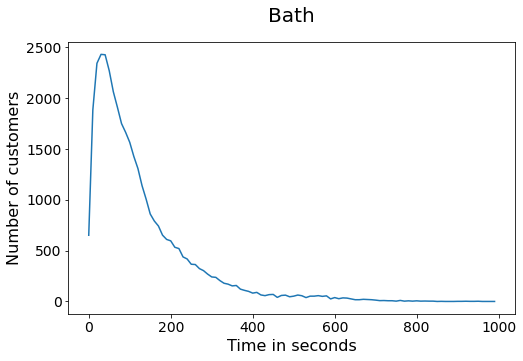

In [243]:
# Show waiting times

x = [i*10 for i in range(100)]
y = [0 for i in range(100)]

for trip_id, trip_info in taxi_trip_infos.items():
    waiting_time = trip_info.waiting_time
    for i in range(len(y)):
        if (10*i < waiting_time < 10*(i+1)):
            y[i] += 1

# title and axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Number of customers")

# plot
plt.plot(x, y)

plt.show()

## **Comparison graphs**

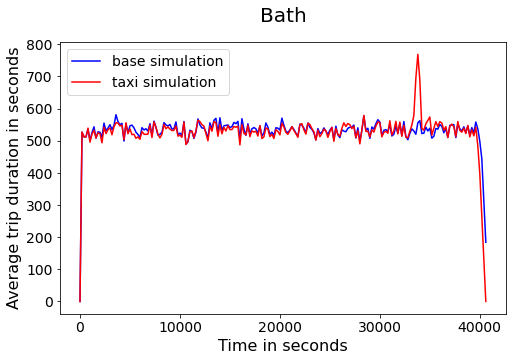

In [244]:
# Average trip duration

gap = 200
graph_range = range(simulation.start_time, simulation.end_time+1200, 200)

base_data = [[0, 0] for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in base_trip_infos.items():
        if time-200 < trip_info.depart_time < time:
            base_data[index][0] += trip_info.duration
            base_data[index][1] += 1
    index += 1

taxi_data = [[0, 0] for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in taxi_trip_infos.items():
        if time-200 < trip_info.depart_time < time:
            taxi_data[index][0] += trip_info.duration
            taxi_data[index][1] += 1
    index += 1

# title, axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Average trip duration in seconds")

# ticks
x_ticks_default = [i for i in range(0, len(graph_range), 50)]
x_ticks = [int(graph_range[i]-simulation.start_time) for i in range(0, len(graph_range), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot([data[0]/data[1] if data[1]!=0 else 0 for data in base_data], "-b", label="base simulation")
plt.plot([data[0]/data[1] if data[1]!=0 else 0 for data in taxi_data], "-r", label="taxi simulation")
plt.legend(loc="upper left")

plt.show()

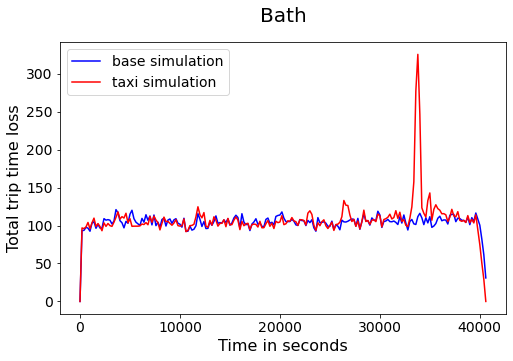

In [245]:
# Average trip time loss

gap = 200
graph_range = range(simulation.start_time, simulation.end_time+1200, 200)

base_data = [[0, 0] for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in base_trip_infos.items():
        if time-200 < trip_info.depart_time < time:
            base_data[index][0] += trip_info.time_loss
            base_data[index][1] += 1
    index += 1

taxi_data = [[0, 0] for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in taxi_trip_infos.items():
        if time-200 < trip_info.depart_time < time:
            taxi_data[index][0] += trip_info.time_loss
            taxi_data[index][1] += 1
    index += 1

# title and axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Average trip time loss")

# ticks
x_ticks_default = [i for i in range(0, len(graph_range), 50)]
x_ticks = [int(graph_range[i]-simulation.start_time) for i in range(0, len(graph_range), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot([data[0]/data[1] if data[1]!=0 else 0 for data in base_data], "-b", label="base simulation")
plt.plot([data[0]/data[1] if data[1]!=0 else 0 for data in taxi_data], "-r", label="taxi simulation")
plt.legend(loc="upper left")

plt.show()

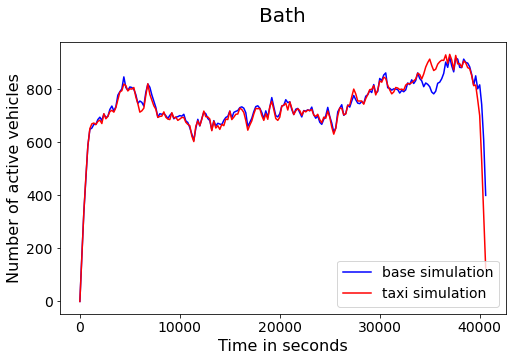

In [246]:
# Number of active vehicles

gap = 200
graph_range = range(simulation.start_time, simulation.end_time+1200, 200)

base_data = [0 for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in base_trip_infos.items():
        if time-200 < trip_info.depart_time < time or time-200 < trip_info.depart_time+trip_info.duration < time or \
            trip_info.depart_time < time-200 and time < trip_info.depart_time+trip_info.duration:
            base_data[index] += 1
    index += 1

taxi_data = [0 for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in taxi_trip_infos.items():
        if time-200 < trip_info.depart_time < time or time-200 < trip_info.depart_time+trip_info.duration < time or \
            trip_info.depart_time < time-200 and time < trip_info.depart_time+trip_info.duration:
            taxi_data[index] += 1
    index += 1

# title and axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Number of active vehicles")

# ticks
x_ticks_default = [i for i in range(0, len(graph_range), 50)]
x_ticks = [int(graph_range[i]-simulation.start_time) for i in range(0, len(graph_range), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot(base_data, "-b", label="base simulation")
plt.plot(taxi_data, "-r", label="taxi simulation")
plt.legend(loc="lower right")

plt.show()

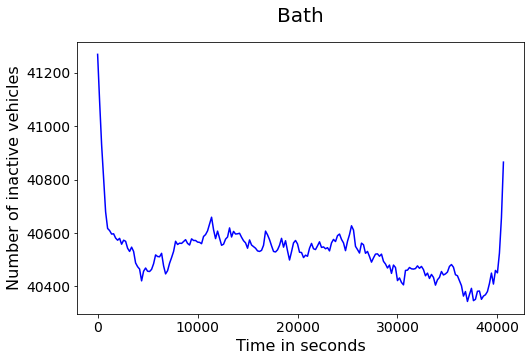

In [247]:
# Number of inactive vehicles

gap = 200
graph_range = range(simulation.start_time, simulation.end_time+1200, 200)

base_data = [0 for _ in graph_range]
index = 0
for time in graph_range:
    for _, trip_info in base_trip_infos.items():
        if time < trip_info.depart_time or trip_info.depart_time+trip_info.duration < time-200:
            base_data[index] += 1
    index += 1

taxi_data = [0 for _ in graph_range]

# title and axis titles
plt.title(simulation.city.name, pad=20)
plt.xlabel("Time in seconds")
plt.ylabel("Number of inactive vehicles")

# ticks
x_ticks_default = [i for i in range(0, len(graph_range), 50)]
x_ticks = [int(graph_range[i]-simulation.start_time) for i in range(0, len(graph_range), 50)]
plt.xticks(x_ticks_default, x_ticks)

# plot
plt.plot(base_data, "-b", label="base simulation")
# plt.plot(taxi_data, "-r", label="taxi simulation")
# plt.legend(loc="center right")

plt.show()